<a href="https://colab.research.google.com/github/cagBRT/Diffusers/blob/main/textual_inversion_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textual inversion

The [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline) supports textual inversion, a technique that enables a model like Stable Diffusion to learn a new concept from just a few sample images. This gives you more control over the generated images and allows you to tailor the model towards specific concepts. You can get started quickly with a collection of community created concepts in the [Stable Diffusion Conceptualizer](https://huggingface.co/spaces/sd-concepts-library/stable-diffusion-conceptualizer).

This guide will show you how to run inference with textual inversion using a pre-learned concept from the Stable Diffusion Conceptualizer. If you're interested in teaching a model new concepts with textual inversion, take a look at the [Textual Inversion](https://huggingface.co/docs/diffusers/main/en/using-diffusers/./training/text_inversion) training guide.

Login to your Hugging Face account:

In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00


In [2]:
!pip3 install accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.5 MB/s eta 0:00:00


In [3]:
import transformers

In [4]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.8 MB/s eta 0:00:00


In [5]:
#from huggingface_hub import notebook_login

#notebook_login()

Import the necessary libraries, and create a helper function to visualize the generated images:

In [6]:
import os
import torch

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [7]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
from pprint import pprint
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
from transformers import TFAutoModelForMaskedLM, AutoTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, top_k_top_p_filtering
from torch import nn
from accelerate import Accelerator
from diffusers import DiffusionPipeline

from diffusers import DDPMPipeline
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from diffusers import StableDiffusionPipeline

Pick a Stable Diffusion checkpoint and a pre-learned concept from the [Stable Diffusion Conceptualizer](https://huggingface.co/spaces/sd-concepts-library/stable-diffusion-conceptualizer):

In [8]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
repo_id_embeds = "sd-concepts-library/cat-toy"

Now you can load a pipeline, and pass the pre-learned concept to it:

In [9]:
pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path,
                                                   torch_dtype=torch.float16).to("cuda")
pipeline.scheduler
pipeline.load_textual_inversion(repo_id_embeds)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Create a prompt with the pre-learned concept by using the special placeholder token `<cat-toy>`, and choose the number of samples and rows of images you'd like to generate:

In [22]:
#prompt = "a grafitti in a favela wall with a <cat-toy> on it"
#prompt = "a hyper-realistic high definition render of <tiny> sitting on a pink rug, 4k"
prompt = "a hyper-realistic high definition render of <elephant> sitting on a pink tree, 4k"
num_samples = 2
num_rows = 2

Then run the pipeline (feel free to adjust the parameters like `num_inference_steps` and `guidance_scale` to see how they affect image quality), save the generated images and visualize them with the helper function you created at the beginning:

In [23]:
generator = torch.Generator(device="cuda").manual_seed(8)
image = pipeline(prompt, generator=generator, num_images_per_prompt=num_samples,
                 num_inference_steps=50, guidance_scale=7.5).images
image

  0%|          | 0/50 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

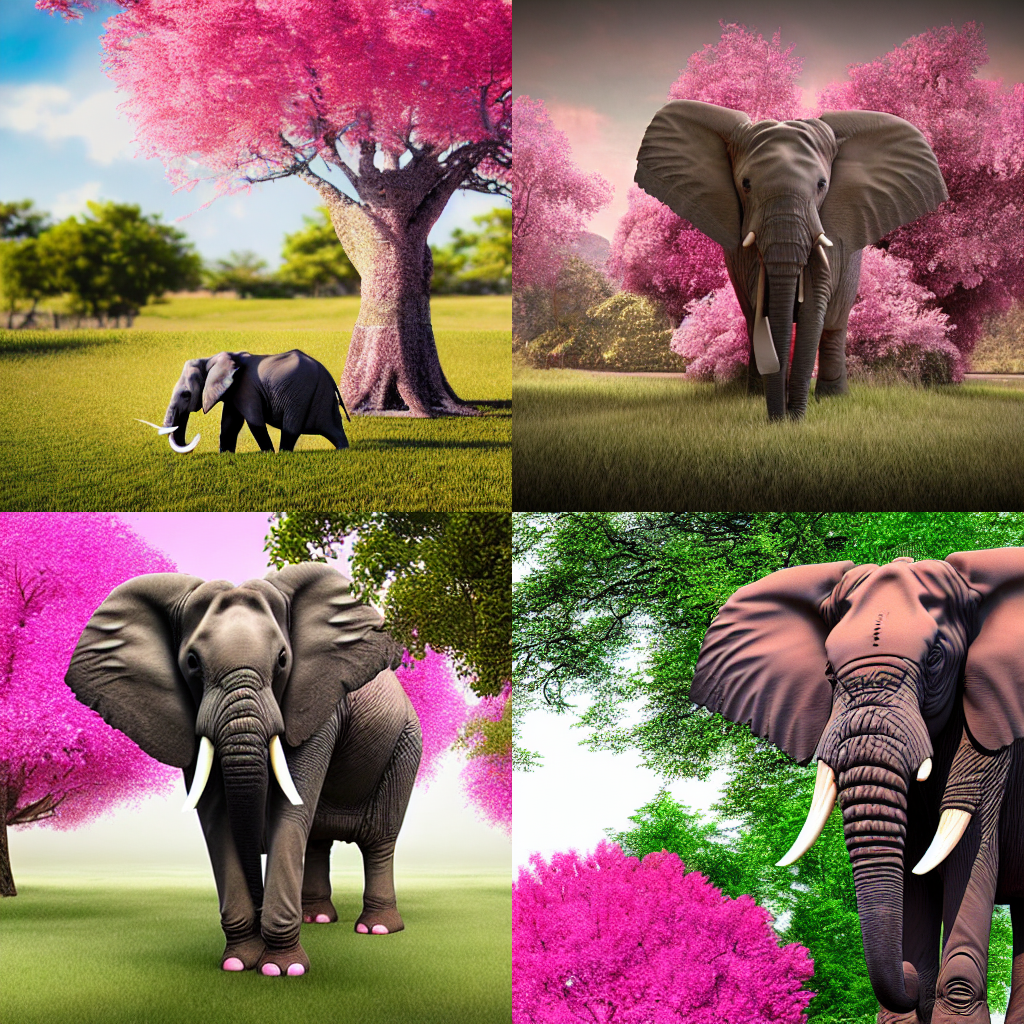

In [24]:
generator = torch.Generator(device="cuda").manual_seed(8)

all_images = []
for _ in range(num_rows):
    images = pipeline(prompt, generator=generator, num_images_per_prompt=num_samples,
                      num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/textual_inversion_inference.png">
</div>